## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [2]:
!pip install keras
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

  Using cached https://files.pythonhosted.org/packages/ad/fd/6bfe87920d7f4fd475acd28500a42482b6b84479832bdc0fe9e589a60ceb/Keras-2.3.1-py2.py3-none-any.whl
You are using pip version 19.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = [ 2, 16, 32, 128, 256 ]
MOMENTUM = 0.95

In [12]:
from keras.layers import Dropout
results = {}

for batch in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    
    print(f"Experiment with BATCH_SIZE = {batch}")
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = f" BATCH_SIZE = {batch}"
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with BATCH_SIZE = 2
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 176s 4ms/step - loss: 2.2885 - accuracy: 0.1519 - val_loss: 3.2224 - val_accuracy: 0.1839
Epoch 2/10
50000/50000 [==============================] - 175s 3ms/step - loss: 2.2297 - accuracy: 0.1681 - val_loss: 2.6120 - val_accuracy: 0.2374
Epoch 3/10
50000/50000 [==============================] - 176s 4ms/step - loss: 2.2190 - accuracy: 0.1733 - val_loss: 2.7528 - val_accuracy: 0.2238
Epoch 4/10
50000/50000 [==============================] - 176s 4ms/step - loss: 2.2158 - accuracy: 0.1755 - val_loss: 2.9866 - val_accuracy: 0.2219
Epoch 5/10
50000/50000 [==============================] - 175s 3ms/step - loss: 2.2124 - accuracy: 0.1779 - val_loss: 2.6300 - val_accuracy: 0.2247
Epoch 6/10
50000/50000 [==============================] - 176s 4ms/step - loss: 2.2171 - accuracy: 0.1786 - val_loss: 2.8931 - val_accuracy: 0.2216
Epoch 7/10
50000/50000 [=======

  Using cached https://files.pythonhosted.org/packages/4e/11/06958a2b895a3853206dea1fb2a5b11bf044f626f90745987612af9c8f2c/matplotlib-3.1.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/5d/bc/1e58593167fade7b544bfe9502a26dc860940a79ab306e651e7f13be68c2/pyparsing-2.4.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
You are using pip version 19.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


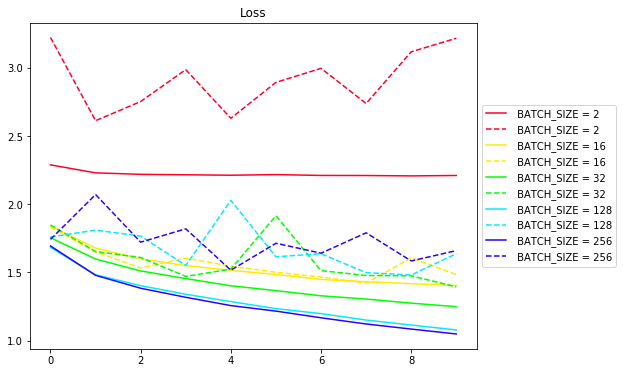

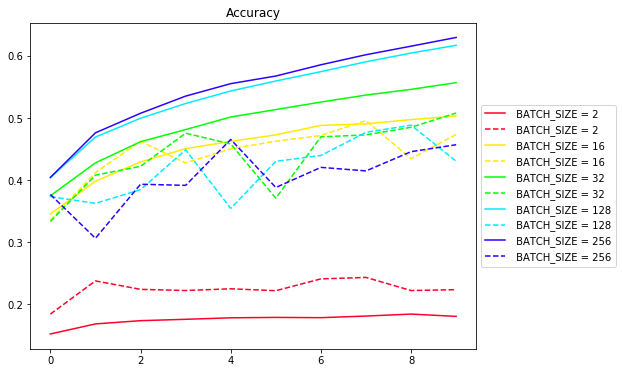

In [14]:
!pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [18]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 128
MOMENTUM = 0.95

output_units=10
num_neurons=[512, 256, 128]
input_shape = x_train.shape[1:]

In [20]:
results = {}
#BN after layer
input_layer = keras.layers.Input(input_shape)

for i, n_units in enumerate(num_neurons):
    if i == 0:
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(input_layer)
        x = BatchNormalization()(x)
    else:
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(x)
        x = BatchNormalization()(x)

out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

model = keras.models.Model(inputs=[input_layer], outputs=[out])
print(model.summary())

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=batch, 
          validation_data=(x_test, y_test), 
          shuffle=True)

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = f" after layer"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

#BN before layer
input_layer = keras.layers.Input(input_shape)

for i, n_units in enumerate(num_neurons):
    if i == 0:
        x = BatchNormalization()(x)
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(input_layer)
        
    else:
        x = BatchNormalization()(x)
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(x)
        

out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

model = keras.models.Model(inputs=[input_layer], outputs=[out])
print(model.summary())

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=batch, 
          validation_data=(x_test, y_test), 
          shuffle=True)

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = f"before layer"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

#BN after input
input_layer = keras.layers.Input(input_shape)
x = BatchNormalization()(x)
for i, n_units in enumerate(num_neurons):
    if i == 0:
        
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(input_layer)
        
    else:
        
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(x)
        

out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

model = keras.models.Model(inputs=[input_layer], outputs=[out])
print(model.summary())

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=batch, 
          validation_data=(x_test, y_test), 
          shuffle=True)

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = f"after input"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}



Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_30 (Batc (None, 128)               512

50000/50000 [==============================] - 4s 80us/step - loss: 1.1499 - accuracy: 0.5920 - val_loss: 1.6020 - val_accuracy: 0.4468
Epoch 8/30
50000/50000 [==============================] - 4s 79us/step - loss: 1.1050 - accuracy: 0.6089 - val_loss: 1.5263 - val_accuracy: 0.4658
Epoch 9/30
50000/50000 [==============================] - 4s 80us/step - loss: 1.0664 - accuracy: 0.6244 - val_loss: 1.7134 - val_accuracy: 0.4160
Epoch 10/30
50000/50000 [==============================] - 4s 80us/step - loss: 1.0365 - accuracy: 0.6354 - val_loss: 1.5298 - val_accuracy: 0.4637
Epoch 11/30
50000/50000 [==============================] - 4s 78us/step - loss: 0.9916 - accuracy: 0.6473 - val_loss: 1.5776 - val_accuracy: 0.4781
Epoch 12/30
50000/50000 [==============================] - 4s 78us/step - loss: 0.9575 - accuracy: 0.6604 - val_loss: 1.8796 - val_accuracy: 0.4080
Epoch 13/30
50000/50000 [==============================] - 4s 78us/step - loss: 0.9318 - accuracy: 0.6698 - val_loss: 1.7622 -

50000/50000 [==============================] - 3s 69us/step - loss: 1.0432 - accuracy: 0.6287 - val_loss: 1.3978 - val_accuracy: 0.5232
Epoch 26/30
50000/50000 [==============================] - 3s 67us/step - loss: 1.0283 - accuracy: 0.6329 - val_loss: 1.3781 - val_accuracy: 0.5307
Epoch 27/30
50000/50000 [==============================] - 3s 67us/step - loss: 1.0157 - accuracy: 0.6365 - val_loss: 1.3803 - val_accuracy: 0.5262
Epoch 28/30
50000/50000 [==============================] - 3s 67us/step - loss: 0.9961 - accuracy: 0.6430 - val_loss: 1.3985 - val_accuracy: 0.5225
Epoch 29/30
50000/50000 [==============================] - 3s 67us/step - loss: 0.9783 - accuracy: 0.6498 - val_loss: 1.4401 - val_accuracy: 0.5259
Epoch 30/30
50000/50000 [==============================] - 3s 67us/step - loss: 0.9566 - accuracy: 0.6573 - val_loss: 1.4561 - val_accuracy: 0.5216


In [22]:

#BN after input
input_layer = keras.layers.Input(input_shape)
x = BatchNormalization()(input_layer)
for i, n_units in enumerate(num_neurons):
    x = keras.layers.Dense(units=n_units, 
                           activation="relu", 
                           name="hidden_layer"+str(i+1))(x)
        

out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

model = keras.models.Model(inputs=[input_layer], outputs=[out])
print(model.summary())

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=batch, 
          validation_data=(x_test, y_test), 
          shuffle=True)

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = f"after input_v2"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}



Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,751,178
Trainable params: 1,745,034
Non-trainable params: 6,144
____________________________________________

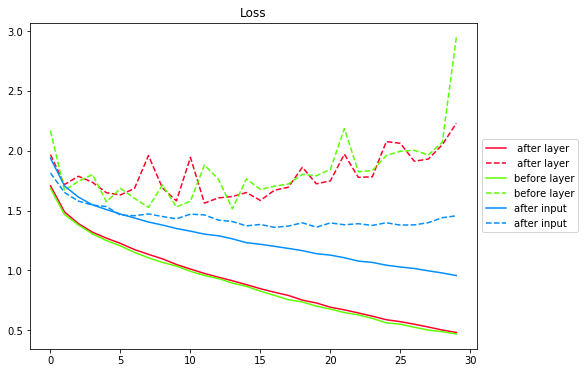

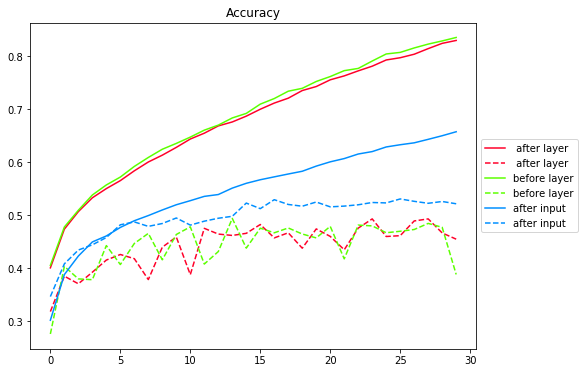

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline 
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

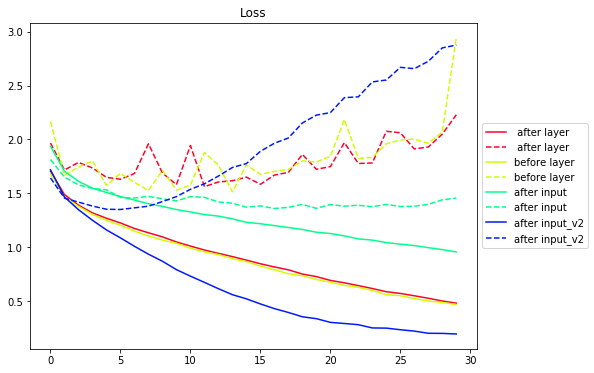

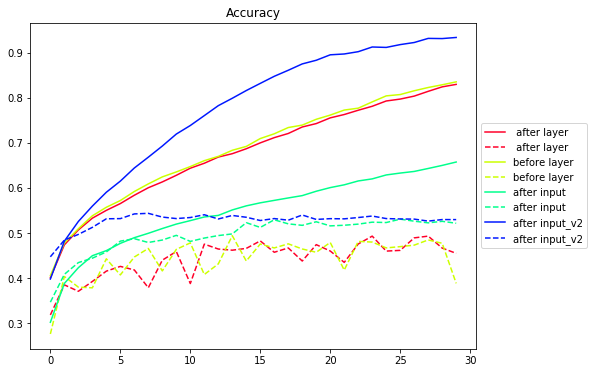

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline 
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()